In [ ]:
!pip install fasttext

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


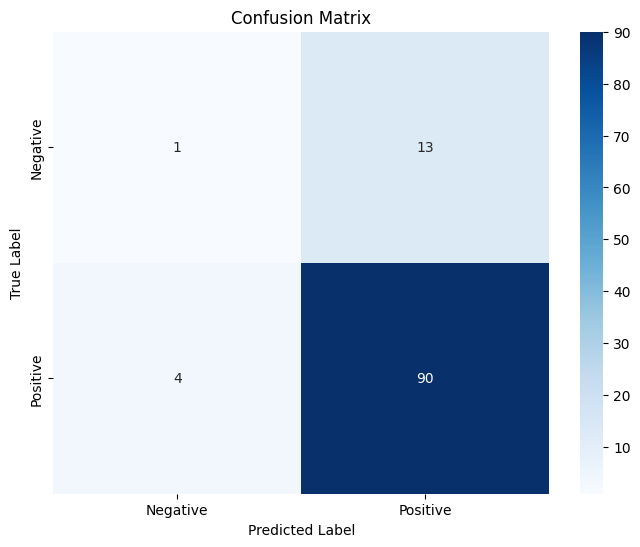

Accuracy: 0.8425925925925926


In [26]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch
from torch import nn
from transformers import BertModel, BertTokenizer
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import seaborn as sns  # Import seaborn for heatmap visualization
from google.colab import drive

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function to preprocess text by removing punctuation, numbers, and stopwords, and applying lemmatization
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Mount Google Drive to access files
drive.mount('/content/drive')

# Load and preprocess data
data_path = '/content/drive/My Drive/experiment/example_hotel_review.csv'
reviews_df = pd.read_csv(data_path)
reviews_df['Processed_Reviews'] = reviews_df['Positive_Review'].str.cat(reviews_df['Negative_Review'], sep=" ").apply(preprocess_text)

# Save processed reviews to a text file for FastText training
reviews_path = '/content/drive/My Drive/experiment/reviews.txt'
reviews_df['Processed_Reviews'].to_csv(reviews_path, index=False, header=False)

# Train FastText model
ft_model = fasttext.train_unsupervised(reviews_path, model='skipgram')
ft_model.save_model('/content/drive/My Drive/experiment/fasttext_model.bin')

# Load FastText and BERT models
fasttext_model = fasttext.load_model('/content/drive/My Drive/experiment/fasttext_model.bin')
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a sentiment analysis model integrating BERT and FastText
class SentimentAnalysisBertModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 1)  # Assuming binary classification


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        return self.classifier(pooled_output)

bert_sentiment_model = SentimentAnalysisBertModel()

def predict_sentiment(texts):
    predictions = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", max_length=128, truncation=True, padding="max_length")
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        with torch.no_grad():
            logits = bert_sentiment_model(input_ids=input_ids, attention_mask=attention_mask)
            predictions.append(torch.sigmoid(logits).item())
    return [1 if p >= 0.5 else 0 for p in predictions]

# Example usage, make sure test_texts is a list of text strings
test_texts = reviews_df['Processed_Reviews'].tolist()
test_labels = (reviews_df['Reviewer_Score'] >= 5).astype(int).tolist()

test_predictions = predict_sentiment(test_texts)
accuracy = accuracy_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy)
